In [7]:
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from preprocessing.config import (
    Config, DatasetConfig, PreprocessingConfig,
    AugmentationConfig, DataLoaderConfig, TransformConfig
)
from preprocessing.dataloader.pipeline import TimeSeriesPipeline
from preprocessing.downloader.huggingface import HuggingFaceDownloader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [12]:
# Download and prepare the Air Passengers dataset
config = Config(
    dataset=DatasetConfig(
        name="air-passengers",
        repo_id="duol/airpassengers",
        files=["AP.csv"]  # Pass as a list to avoid string splitting
    ),
    preprocessing = PreprocessingConfig(
    transforms=[
        TransformConfig(
            name="MeanScaler",
            params={
                "epsilon": 1e-8
            }
        )
    ]
    ),
    augmentation = AugmentationConfig(
        enabled=False
    ),
    # dataloader = DataLoaderConfig(
    #     batch_size=32
    # )
)

# Download the dataset
downloader = HuggingFaceDownloader(config.dataset)
data_path = downloader.download()["AP.csv"]  # Get the path from the returned dict

# Read and prepare the CSV data
import pandas as pd
df = pd.read_csv(data_path)
data = df['#Passengers'].values  # Get passenger counts
data = torch.FloatTensor(data).reshape(12, 12, 1)

print("Data shape:", data.shape)  # Print shape for debugging

# Create dataset with just the input data (no targets needed)
dataset = TensorDataset(data)


Data shape: torch.Size([12, 12, 1])


In [14]:

# Create pipeline and dataloader
pipeline = TimeSeriesPipeline(config)
dataloader = pipeline.create_dataloader(dataset)


In [15]:
processed_batch = next(iter(dataloader))

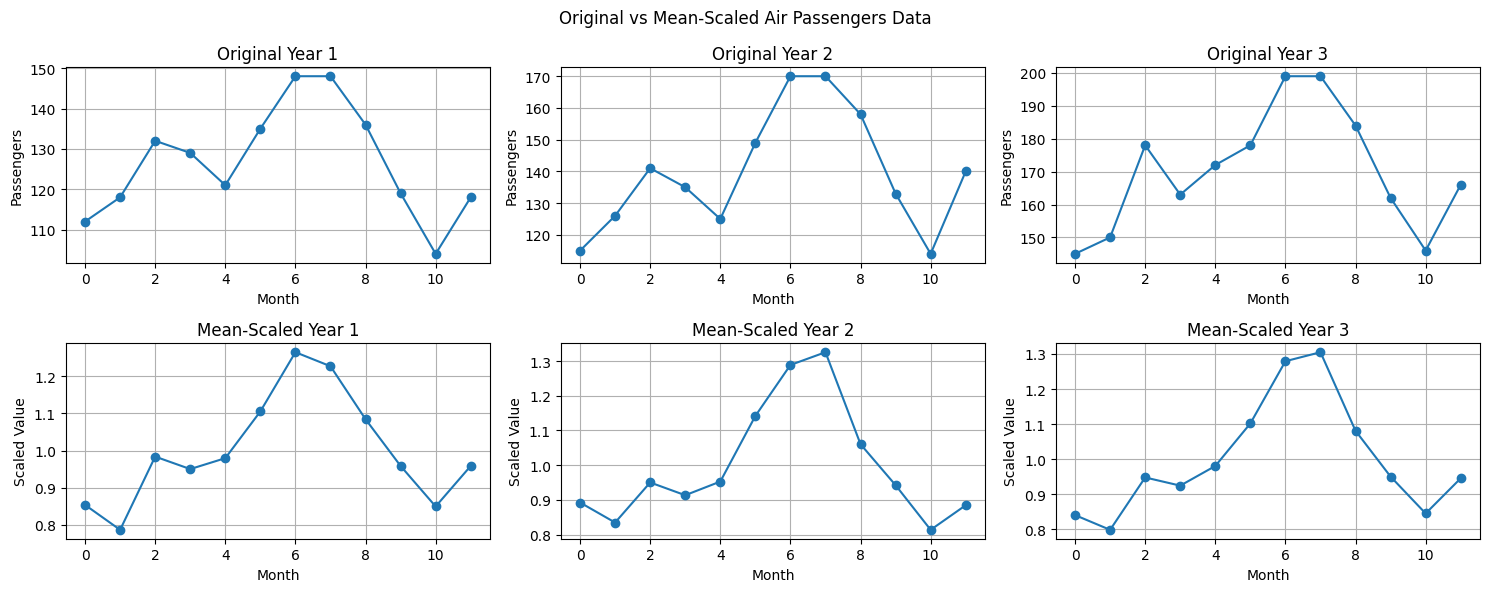

In [16]:
# Visualize original and processed data
def plot_samples(original_batch, processed_batch, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Original vs Mean-Scaled Air Passengers Data')
    
    for i in range(num_samples):
        # Plot original
        axes[0, i].plot(original_batch[i, :, 0].numpy(), marker='o')
        axes[0, i].set_title(f'Original Year {i+1}')
        axes[0, i].set_xlabel('Month')
        axes[0, i].set_ylabel('Passengers')
        axes[0, i].grid(True)
        
        # Plot processed
        axes[1, i].plot(processed_batch[i, :, 0].numpy(), marker='o')
        axes[1, i].set_title(f'Mean-Scaled Year {i+1}')
        axes[1, i].set_xlabel('Month')
        axes[1, i].set_ylabel('Scaled Value')
        axes[1, i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get first 3 years of data and debug shapes
original_batch = next(iter(DataLoader(dataset, batch_size=3, shuffle=False)))
processed_batch = next(iter(dataloader))


# Extract tensors properly
original_tensor = original_batch[0]
processed_tensor = processed_batch

plot_samples(original_tensor, processed_tensor, 3)
